In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Column names and types for each class
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])
print("---------")
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

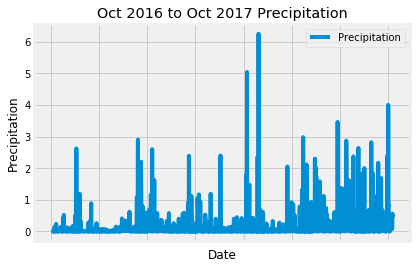

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 2 years ago from today
date_start = dt.date.today() - dt.timedelta(days = 365)
date_end = dt.date.today() - dt.timedelta(days = (365 * 2))

# Perform a query to retrieve the data and precipitation scores
q = session.query(Measurement.prcp, Measurement.date)\
.filter(and_(Measurement.date <= date_start, Measurement.date >= date_end))

# Save the query results as a Pandas DataFrame and set the index to the date column
precip = [row[0] for row in q]
date = [row[1] for row in q]
frame = pd.DataFrame(precip, date, columns = ["Precipitation"])
frame = frame.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
frame.plot()
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Oct 2016 to Oct 2017 Precipitation")

# Rotate the xticks for the dates
plt.xticks(rotation = 90)
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
frame.describe()

,Precipitation
count,1777.000000
mean,0.160501
std,0.426060
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


In [13]:
# How many stations are available in this dataset?
q = session.query(func.count(distinct(Measurement.station)))
for row in q:
    print(row)

(9,)


In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
q = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station)\
.order_by(func.count(Measurement.prcp).desc())
for row in q:
    print(row)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
q = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station == "USC00519281")

for row in q:
    print(row)

(54.0, 85.0, 71.66378066378067)


Text(0,0.5,'Temperature')

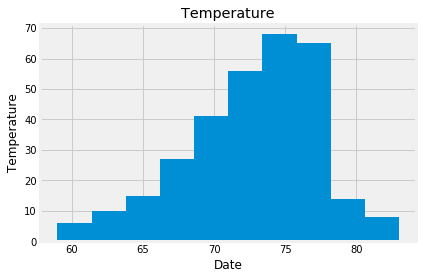

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
q = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == "USC00519281")\
.filter(and_(Measurement.date <= date_start, Measurement.date >= date_end))

date = [row[0] for row in q]
temp = [row[1] for row in q]
frame = pd.DataFrame(temp, date, columns = ["Temperature"])
frame = frame.dropna()

frame.hist()
plt.xlabel("Date")
plt.ylabel("Temperature")

In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2016-02-28', '2016-03-05')

[(62.0, 69.88636363636364, 80.0)]

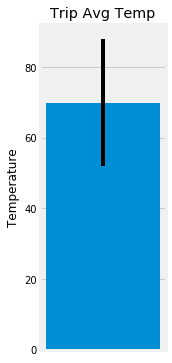

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = calc_temps('2016-02-28', '2016-03-05')[0][0]
tavg = calc_temps('2016-02-28', '2016-03-05')[0][1]
tmax = calc_temps('2016-02-28', '2016-03-05')[0][2]

fig, ax = plt.subplots(figsize = (2, 6))
ax.bar(0, tavg, yerr = (tmax - tmin))
ax.get_xaxis().set_visible(False)
plt.ylabel("Temperature")
plt.title("Trip Avg Temp")
plt.show()

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
cols = [Measurement.station, Station.name, func.avg(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]

q = session.query(*cols).filter(Measurement.station == Station.station)\
.filter(Measurement.date >= '2016-02-28').filter(Measurement.date <= '2016-03-05')\
.group_by(Measurement.station).order_by(func.avg(Measurement.prcp).desc())

for row in q:
    print(row)

('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.047142857142857146, 21.33556, -157.71139, 19.5)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.017142857142857144, 21.5213, -157.8374, 7.0)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 0.004, 21.3331, -157.8025, 152.4)
('USC00519281', 'WAIHEE 837.5, HI US', 0.0014285714285714286, 21.45167, -157.84888999999998, 32.9)
('USC00513117', 'KANEOHE 838.1, HI US', 0.0, 21.4234, -157.8015, 14.6)
('USC00519397', 'WAIKIKI 717.2, HI US', 0.0, 21.2716, -157.8168, 3.0)
('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [60]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
end_date = dt.datetime.strptime('2016-03-05', '%Y-%m-%d')
start_date = dt.datetime.strptime('2016-02-28', '%Y-%m-%d')                           
                           
# Use the start and end date to create a range of dates
dates = []
for n in range(int((end_date - start_date).days)):
    dates.append(start_date + dt.timedelta(n))
dates

# Stip off the year and save a list of %m-%d strings
dates = [date.strftime("%m-%d") for date in dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
#temp_data = [daily_normals(date) for date in dates]

daily_normals(dates[0])[0]

(65.0, 70.65517241379311, 80.0)

In [55]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_data

[[(65.0, 70.65517241379311, 80.0)],
 [(67.0, 71.73333333333333, 79.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)]]

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
